In [1872]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

In [1873]:
df = pd.read_csv('./data/incoming_packages.csv')

# ● Analysera datan

In [1874]:
df.head()

,date,total_packages,cooled_packages,fire_packages,normal_packages
0,2020-01-01,1745,370,488,887
1,2020-01-02,1847,308,402,1137
2,2020-01-03,1842,314,394,1134
3,2020-01-04,664,131,181,352
4,2020-01-05,871,137,190,544


In [1875]:
df.isnull().sum()

date               0
total_packages     0
cooled_packages    0
fire_packages      0
normal_packages    0
dtype: int64

In [1876]:
df.duplicated().sum()

0

In [1877]:
total_df = df[['date','total_packages']]

In [1878]:
total_df['date'] = pd.to_datetime(total_df['date'])

C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\1963213863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['date'] = pd.to_datetime(total_df['date'])


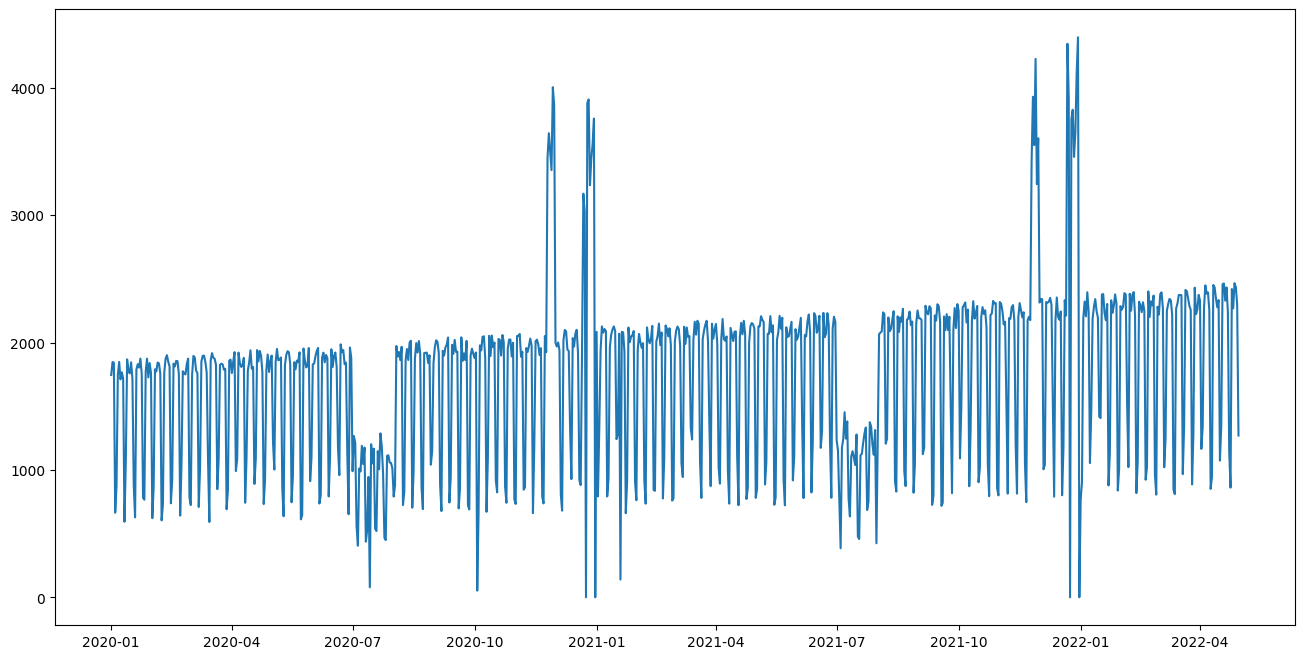

In [1879]:
plt.figure(figsize=(16,8))
plt.plot(total_df['date'], total_df['total_packages'])
plt.show()

## ○ Finns det någon säsongsvariation? I så fall, vilka?

### Som det ser ut så håller den en säsongsvariation där det transporteras mindre paket på sommaren och sedan transporteras många paket under November - December, och mellan det så följer det en säsongsvariation som jag misstänker vara vardagar då det skickas som mest paket och sedan helgdagar som det skickas betydligt mindre paket, därav upp och nedgången.

## ○ Det finns spikar i november och december, vad kan det bero på?

### Anledningen till att det är många transporter under November och December skulle jag nog säga beror på Black friday och Julafton, då det säljs mycket i butiker och nätbutiker så kommer många transporter att genomföras

## ○ Finns det någon trend?

In [1880]:
total_df['year'] = total_df['date'].dt.year
total_df['month'] = total_df['date'].dt.month

C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\279062232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['year'] = total_df['date'].dt.year
C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\279062232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_df['month'] = total_df['date'].dt.month


In [1881]:
monthly_trend = total_df.groupby(['year', 'month'])['total_packages'].mean()

In [1882]:
yearly_trend = total_df.groupby(['year'])['total_packages'].mean().reset_index()

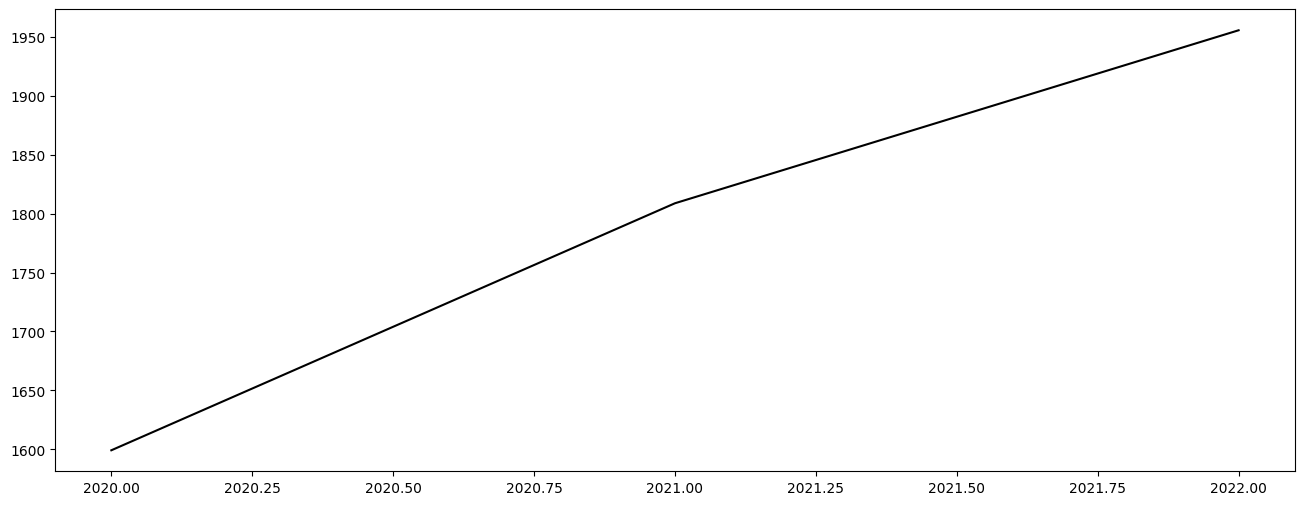

In [1883]:
plt.figure(figsize=(16,6))
plt.plot(yearly_trend['year'], yearly_trend['total_packages'], c='black')
# plt.xticks([
#     '2020-01', '2021-01','2022-01'
# ])
plt.show()

### Som vi ser i grafen så är det en trend uppåt, jag valde att dela in det per år eftersom att vi inte har fullständig data från 2022, men att det fortfarande var intressant att se hur mycket mer det går i början av året även fast november och december topparna inte blir inräknade, men annars så kan man nästan förutspå att trenden kommer öka som den gjort från 2020 till 2021.

In [1884]:
for i in range(len(yearly_trend['year'])):
    yearly_trend['year'][i] = str(yearly_trend['year'][i]) + '-01-01'

C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\1544917876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_trend['year'][i] = str(yearly_trend['year'][i]) + '-01-01'


In [1885]:
yearly_trend['year'] = pd.to_datetime(yearly_trend['year'])

In [1886]:
total_df = total_df.drop(columns=['year','month'])

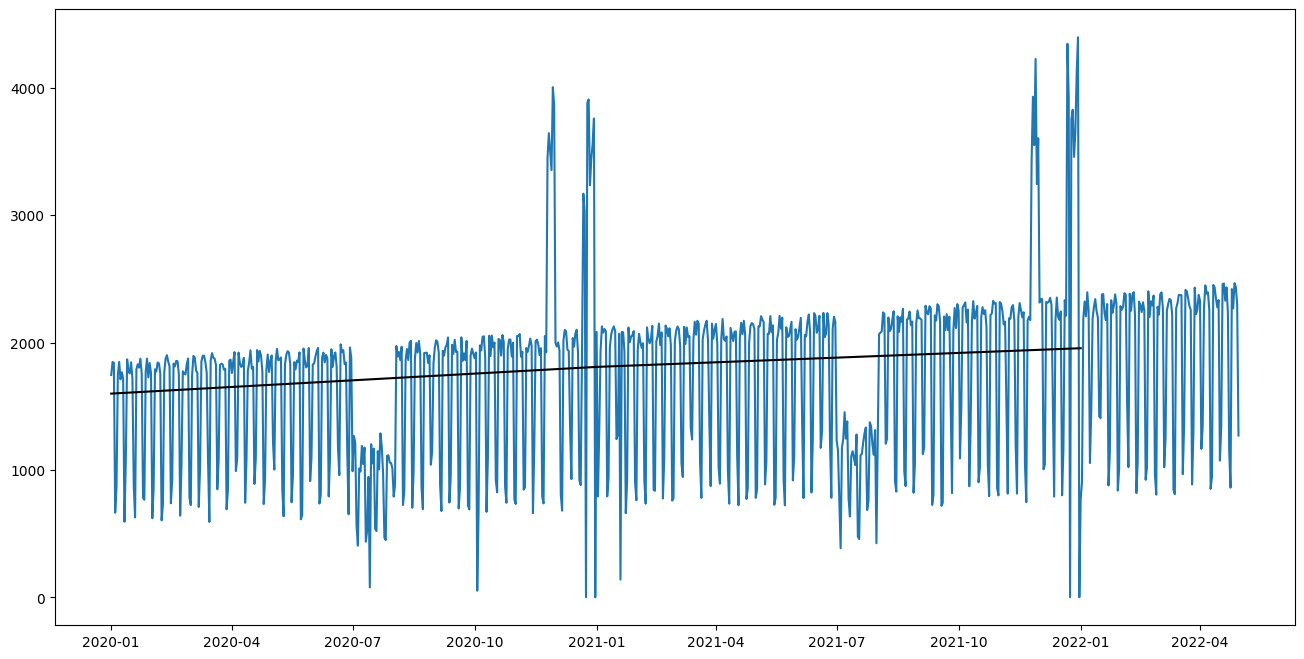

In [1887]:
# yearly_trend.plot(figsize=(16,8))
plt.figure(figsize=(16,8))
plt.plot(total_df['date'], total_df['total_packages'])
plt.plot(yearly_trend['year'], yearly_trend['total_packages'], c='black')
plt.show()

### Här ser vi trenden tillsammans med våran data, vi ser att den inte får fullständig data från 2022, men även med det den har fått så ser vi en stigande trend från 2021.

### För att göra det extra tydligt så grupperar jag dom för varje månad och tar medelvärdet av totala antalet transporter per månad och ritar ut, då ser vi klart och tydligt att det ökar.

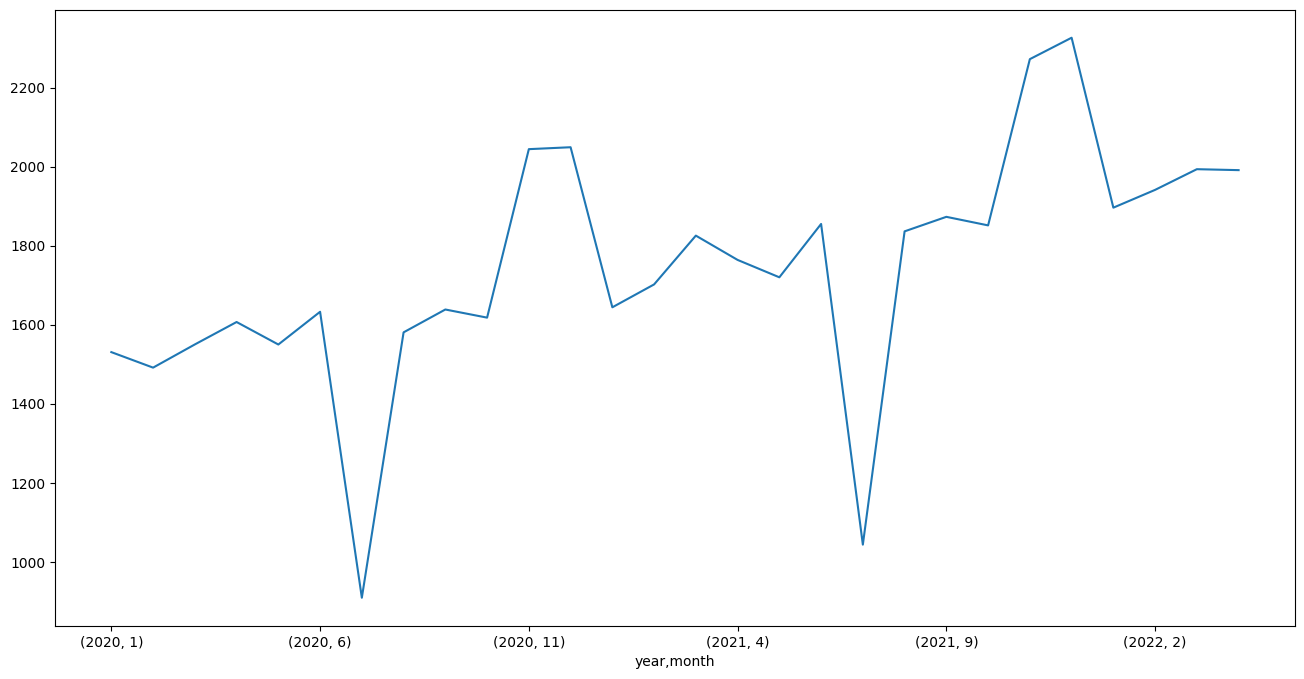

In [1888]:
monthly_trend.plot(figsize=(16,8))
plt.show()

In [1889]:
total_df = total_df.rename(columns={'date':'ds','total_packages':'y'})

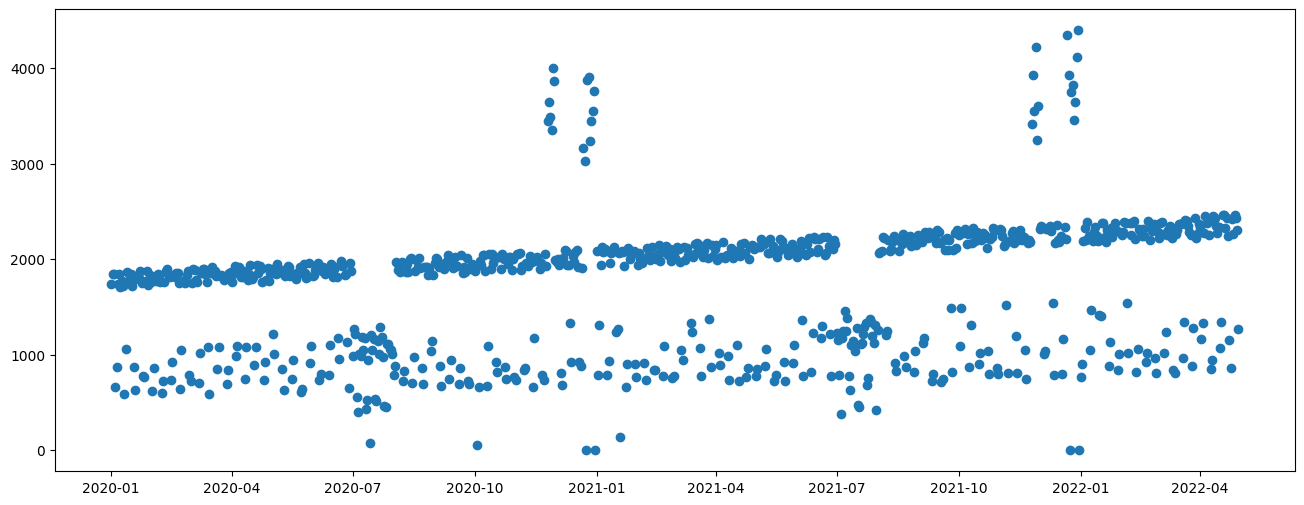

In [1890]:
plt.figure(figsize=(16,6))
plt.scatter(total_df['ds'],total_df['y'])
plt.show()

### Som vi ser så följer transporterna en sakta men stadig ökning uppåt, det man ser är ju att det som formar som en linje är ju vardagstransporterna och det som hamnar under är under helgen då det inte transporteras lika mycket.
### Vi ser även det vi nämnde tidigare att det är en dipp under sommaren i början på juli, vi ser både extrema värden uppåt under november och december och sedan väldigt låga värden neråt, dessa ska vi kika lite närmare på för att fastställa våran analys angående spikarna i November och December. Men även varför det finns dagar där det inte har transporterats någonting alls.

## ○ Finns det några dagar med extrema värden?

### Jag väljer att ta ut dom dagar som har över 2600 transporter som extremvärden, men också ta ut dom dagar som har under 500 transporter som lägsta värden.

In [1891]:
extreme = total_df[total_df['y'] > 2600]

In [1892]:
lowest = total_df[total_df['y'] < 500]

In [1893]:
extreme

,ds,y
329,2020-11-25,3452
330,2020-11-26,3644
331,2020-11-27,3494
332,2020-11-28,3354
333,2020-11-29,4005
334,2020-11-30,3865
356,2020-12-22,3169
357,2020-12-23,3030
359,2020-12-25,3881
360,2020-12-26,3909


### Här ser vi precis som vi har spekulerat tidigare att i november så startar black friday den 24e november, och det är mellan 25-30e som vi ser en spike i transporter. Sedan ser vi hur det inför julen och ut över mellandagarna kommer en till spike.

In [1894]:
lowest

,ds,y
186,2020-07-05,405
192,2020-07-11,437
195,2020-07-14,78
206,2020-07-25,468
207,2020-07-26,449
276,2020-10-03,52
358,2020-12-24,0
365,2020-12-31,0
384,2021-01-19,139
550,2021-07-04,385


### Det första vi lägger märke till här är ju såklart att julafton och nyårsafton så sker ju inga transporter, och det hade man kunnat tänka sig innan. Det vi även ser är att under juni så kommer det under våran minumum på 500 transporter, men dessa är helger. Men det som är intressant är dom dagarna som har väldigt få transporter runt 100 och mindre, kanske att det är någon högtid som jag inte tänker på eller om det har varit någon typ av underhåll hos transportören.

# ● Träna en facebook prophet modell
## ○ Träna modellen på all data före 2022-04-01
## ○ Testa modellen på all data från 2022-04-01 och framåt

### Jag skapar upp en funktion för att splitta datasetet vid ett datum, eftersom att jag kommer behöva göra det igen

In [1895]:
def splitting_on_date(data, date:str):
    train_df = data[data['ds'] < date]
    test_df = data[data['ds'] >= date]
    return train_df,test_df

In [1896]:
train_df, test_df = splitting_on_date(total_df, '2022-04-01')

In [1897]:
model = Prophet().fit(train_df)

22:32:01 - cmdstanpy - INFO - Chain [1] start processing
22:32:01 - cmdstanpy - INFO - Chain [1] done processing


In [1898]:
forecast = model.predict(train_df)

### Jag väljer att först rita ut enbart modellen med träningsdatan och beskriver vad det är vi ser sedan nedanför så kommer jag rita ut vad den predictar för april.

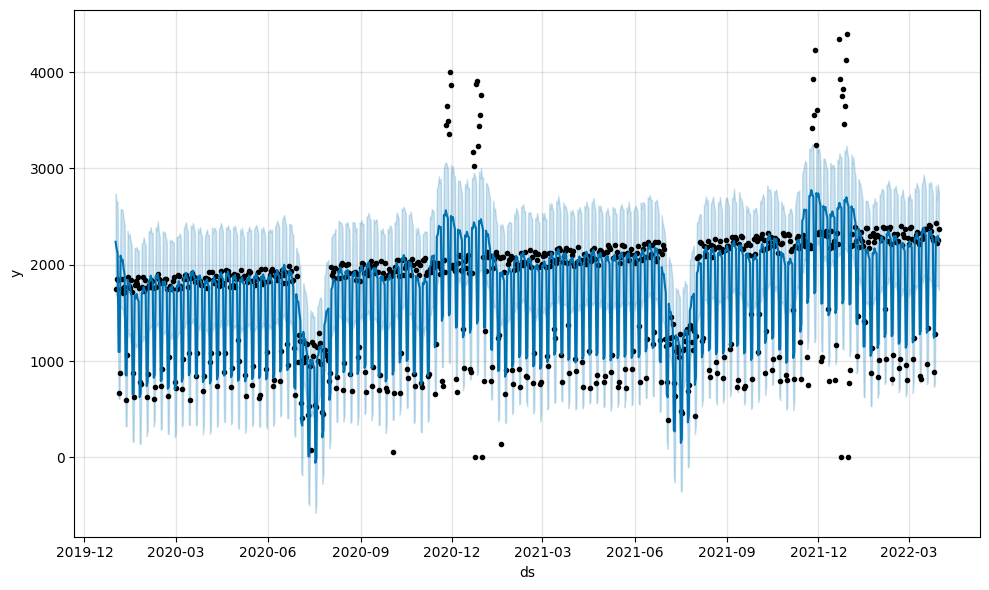

In [1899]:
model.plot(forecast)
plt.show()

## ■ Vad ser vi i grafen?
## ● Svarta punkter
## ● Mörkblå linje
## ● Ljusblå linje


### Dom svarta punkterna vi ser i grafen är våran fakstiska träningsdata.
### Den mörkblå linjen är trenden som har genererats av modellen
### Den ljusblå linjen är intervallet för dom förutsagda värdena, det ger en indikation på osäkerheten kring prognosen.

## ○ Hur modellen har prognostiserat träningsdatan

In [1900]:
len(test_df)

30

### Eftersom att våran testdata när vi delade upp den enbart innehåller april månad så vill jag göra en prediction på samma tidsperiod

In [1901]:
future = model.make_future_dataframe(periods=30)

In [1902]:
april_forecast = model.predict(future)

<Figure size 1600x800 with 0 Axes>

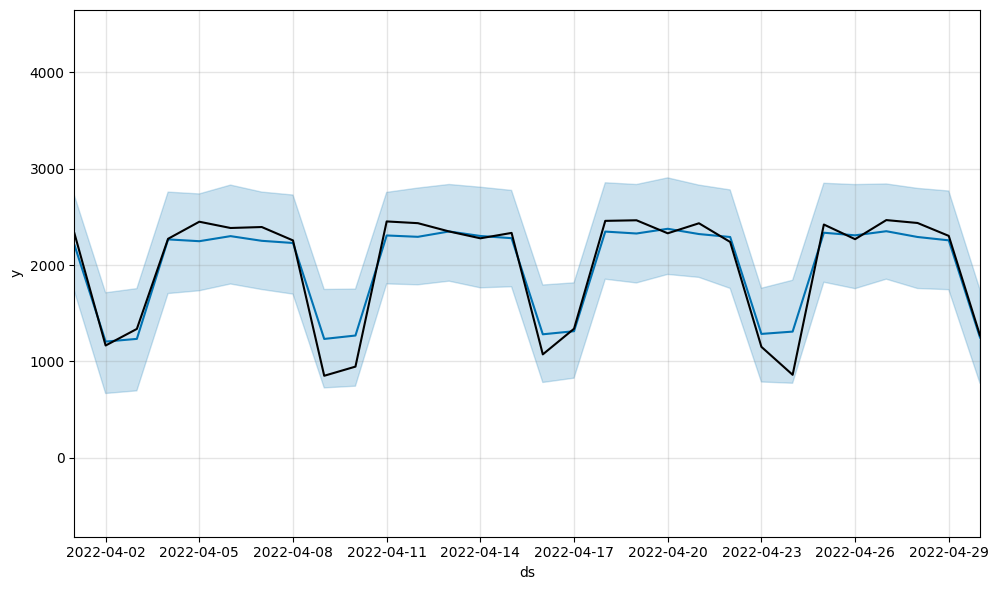

In [1903]:
# Jag kommer välja att när jag ska rita ut modellen att plotta direkt från den sedan begränsa x-axeln tilln månaden jag vill kolla på, istället för att köra plt.plot()
# Detta eftersom att vi får med även den ljusbblå  ytan som beskriver osäkerheten.
plt.figure(figsize=(16,8))
model.plot(april_forecast)
plt.plot(test_df['ds'],test_df['y'], c='black')
start_date = pd.to_datetime('2022-04-01')
end_date = pd.to_datetime('2022-04-30')
plt.xlim(start_date,end_date)
plt.show()

### Ovanför så ser vi grafen med värdena från april det svarta strecket som är dom riktiga värdena för antalet paket, sedan det blå strecket som är vad modellen har predictat

## ○ Rita ut modellens komponenter (trend och säsongsvariation)

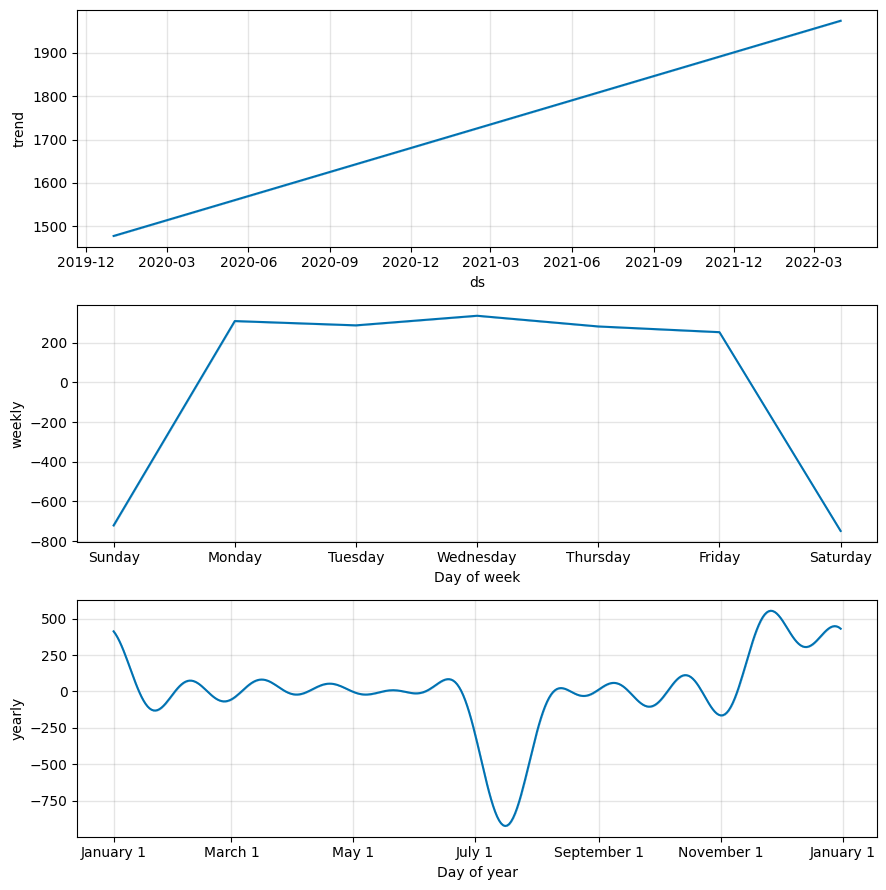

In [1904]:
model.plot_components(forecast)
plt.show()

### Här ser vi modellens komponenter, vi ser i trenden precis som i min egna analys att det går stadigt uppåt till fler transporter för varje dag. Vi ser även en säsongsvariation på veckodagar där jag också var lite inne på tidigare att det är vardagar som det skickas mest paket, och sist ser vi säsongsvariationen för året där precis som jag nämnde tidigare så går transporterna ner under juli månad och sedan så spikar det under november och december.

# ● Kör modellen mot testdatan och se om den presterar bättre än planeringen på 2000 paket om dagen.


In [1905]:
dataset = pd.DataFrame({'value': [2000] * 30})

### Eftersom att ursprungliga planeringen var 2000 paket om dagen så har jag nu skapat upp ett dataset som är under samma period (30 dagar) som vår testdata för att se hur bra planeringen är.

In [1906]:
april_forecast = april_forecast[april_forecast['ds'] >= '2022-04-01']

## ○ För att jämföra modellen med ursprungliga planeringen ska MAE (mean absolute error) användas

In [1907]:
print(f"MAE för ursprunliga planeringen: {mean_absolute_error(dataset['value'],test_df['y'])}")
print(f"MAE för modellens prediktion: {mean_absolute_error(test_df['y'],april_forecast['yhat'])}")

MAE för ursprunliga planeringen: 524.9666666666667
MAE för modellens prediktion: 117.5138924020347


### När man använder MAE så vill man ha en så lågt värde som möjligt.
### Vi ser då att resultatet för modellens prediktion är betydligt bättre än den ursprungliga planeringen på 2000 paket om dagen. Men denna hade man ju även kunnat finslipa genom att räkna med ett antal på vardagar och ett annat antal på helger, då 2000 per dag är väldigt hårddraget.

In [1908]:
from datetime import datetime

vardag = []
helg = []
for index, days in enumerate(test_df['ds']):
    if datetime.weekday(days) == 5 or datetime.weekday(days) == 6:
        helg.append(test_df['y'].iloc[index])
    else: 
        vardag.append(test_df['y'].iloc[index])

In [1909]:
vardagar = sum(vardag)/len(vardag)

In [1910]:
helger = sum(helg)/len(helg)

In [1911]:
lista = []
for days in test_df['ds']:
    if datetime.weekday(days) == 5 or datetime.weekday(days) == 6:
        lista.append({'value': helger})
    else: 
        lista.append({'value': vardagar})

In [1912]:
dataset = pd.DataFrame(lista)

In [1913]:
mean_absolute_error(dataset['value'],test_df['y'])

96.33333333333333

### Bara för att jag ville utforska lite så testade jag att göra en egen planering som är baserad på testdatan under april och tar genomsnittet under vardagar och genomsnittet under helger och sätter in det i ett dataset och testar MAE värdet på, detta blir det absolut bästa. Men med det sagt så har jag ju också bara testat det på den senast loggade månaden, medans modellen tar ju in all data från tidigare för att göra prediktionen under april, vilket gör att man kommer kunna längre fram samt se säsongsvariationerna på ett annat sätt, annars när vi kommer till juli månad när det har varit en dipp tidigare år om man gör som jag precis gjorde så kommer man beräkna paket utifrån juli vilket kommer bli på tok för mycket. 
### Det man kan göra om man vill göra ett helt eget exempel är att ta fram procentuellt hur mycket transporterna ökar per månad för varje år och på så sätt få fram stabilare data, men då är det ju ändå smidigare att bara träna modellen som förutspår åt en.

# ● Gör en prognostisering för Juni 2022 och rita ut.

In [1914]:
future = model.make_future_dataframe(periods=91)

In [1915]:
june_total_package_forecast = model.predict(future)

In [1916]:
june_forecast = june_total_package_forecast[june_total_package_forecast['ds'] >= '2022-06-01']

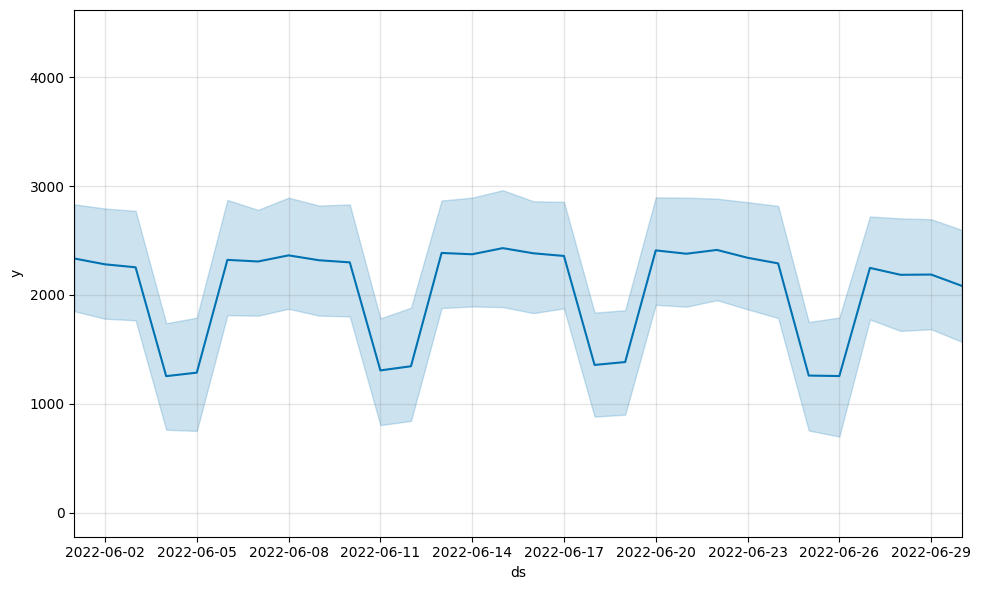

In [1917]:
# Även här väljer jag att plotta från modellen för att få med den ljusblå ytan och begränsa x-axeln.
model.plot(june_forecast)
start_date = pd.to_datetime('2022-06-01')
end_date = pd.to_datetime('2022-06-30')
plt.xlim(start_date,end_date)
plt.show()

# VG

In [1918]:
cool_df = df[['date','total_packages','cooled_packages']]
fire_df = df[['date','total_packages','fire_packages']]
normal_df = df[['date','total_packages','normal_packages']]

In [1919]:
cool_df['date'] = pd.to_datetime(cool_df['date'])
fire_df['date'] = pd.to_datetime(fire_df['date'])
normal_df['date'] = pd.to_datetime(normal_df['date'])

C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\1680359581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cool_df['date'] = pd.to_datetime(cool_df['date'])
C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\1680359581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_df['date'] = pd.to_datetime(fire_df['date'])
C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\1680359581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [1920]:
cool_df = cool_df.rename(columns={'date':'ds','cooled_packages':'y'})
fire_df = fire_df.rename(columns={'date':'ds','fire_packages':'y'})
normal_df = normal_df.rename(columns={'date':'ds','normal_packages':'y'})

# ● Varje modell ska tränas på data före 2022-04-01 och testas på data från 2022-04-01.

In [1921]:
cool_df_train, cool_df_test = splitting_on_date(cool_df, '2022-04-01')
fire_df_train, fire_df_test = splitting_on_date(fire_df, '2022-04-01')
normal_df_train, normal_df_test = splitting_on_date(normal_df, '2022-04-01')

# ● Träna ytterligare tre facebook prophet modeller.
## ○ En för normala paket.
## ○ En för kylda paket.
## ○ En för brandfarliga paket.

In [1922]:
cool_model = Prophet()
fire_model = Prophet()
normal_model = Prophet()

## ○ Prognostiseringen för totala antalet paket ska användas som input för varje modell.

### Eftersom att i uppgiften så skulle prognostiseringen för totala antalet paket och inte dom faktiska antalet paket skickas med så tog jag den tidigare prognostiseringen från G delen och använder den här till dom olika dataseten.
### Men om man skulle vilja byta ut så att den använder dom riktiga värdena för totala antalet paket så kan man kommentera bort nedanstående rader.

In [1923]:
cool_df_train['total_packages'] = forecast['yhat']
fire_df_train['total_packages'] = forecast['yhat']
normal_df_train['total_packages'] = forecast['yhat']

C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\991897321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cool_df_train['total_packages'] = forecast['yhat']
C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\991897321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_df_train['total_packages'] = forecast['yhat']
C:\Users\Nicla\AppData\Local\Temp\ipykernel_26000\991897321.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [1924]:
cool_model.add_regressor('total_packages')
fire_model.add_regressor('total_packages')
normal_model.add_regressor('total_packages')

In [1925]:
cool_model.fit(cool_df_train)
fire_model.fit(fire_df_train)
normal_model.fit(normal_df_train)

22:32:05 - cmdstanpy - INFO - Chain [1] start processing
22:32:05 - cmdstanpy - INFO - Chain [1] done processing
22:32:05 - cmdstanpy - INFO - Chain [1] start processing
22:32:05 - cmdstanpy - INFO - Chain [1] done processing
22:32:05 - cmdstanpy - INFO - Chain [1] start processing
22:32:05 - cmdstanpy - INFO - Chain [1] done processing


# ● För varje modell ska följande göras
### ○ Räkna ut medelvärdet av fel för varje dag i testdatan
### ■ Här har företaget inget eget värde att jämföra mot
### ○ Rita ut modellens komponenter (trend och säsongsvariation)
### ○ Gör en prognostisering för Juni 2022 och rita ut.

### Jag väljer att skapa en funktion som gör samtliga saker i följd efter varandra så det blir mindre grötigt
### Eftersom att vi behöver en forecast med totala antalet paket som input så eftersom att vi gjorde det i G delen så återanvänder jag den här.

In [1926]:
def draw_component_prog_June(model, train, test, total_package_forecast):
    # Först gör vi en predict som vi sedan kan rita ut komponenterna för
    forecast = model.predict(train)
    # Här skapar vi upp predict för framtiden fram till och med juni eftersom att det kommer vi behöva senare
    future = model.make_future_dataframe(periods=91)
    # Eftersom att vi inte vet vad dom totala paketen är så behöver vi predicten som vi gjorde i  G delen med totala paket som vi stoppar in i predicten
    future['total_packages'] = total_package_forecast['yhat']
    # Här skapar vi upp dataset som enbart innehåller  april samt juni eftersom att det är det som behövs i uppgiften
    future = future[future['ds'] >= '2022-04-01']
    june_future = future[future['ds'] >= '2022-06-01']
    april_future = future[future['ds'] < '2022-05-01']
    april_future_forecast = model.predict(april_future)
    june_future_forecast = model.predict(june_future)
    # Här tar vi fram medelvärdet av fel för varje dag i testdatan under april occh sedan skriver ut det
    # Eftersom att uppgiften sa att jag skulle räkna ut medelvärdet för varje dag och inte rakt av använd MAE som vi gjort i G delen 
    # och för att jag ville testa att göra en egen så gjorde jag en egen för att räkna men om man vill använda den färdiga funktionen så kan man kommentera bort min och använda den nedanför.
    difference = []
    for i in range(len(test)):
        difference.append(max(test['y'].iloc[i],april_future_forecast['yhat'].iloc[i]) - min(test['y'].iloc[i],april_future_forecast['yhat'].iloc[i]))
    difference = sum(difference)/len(test)
    # difference = mean_absolute_error(test['y'],april_future_forecast['yhat'])
    print(f'Medelvärdet av fel för varje dag i testdatan: {difference}')
    # Här plottar vi modellens komponenter
    model.plot_components(forecast)
    plt.show()
    # Och sist så plottar vi för Juni, jag valde att begränsa grafen till just den månaden
    model.plot(june_future_forecast)
    start_date = pd.to_datetime('2022-06-01')
    end_date = pd.to_datetime('2022-06-30')
    plt.xlim(start_date,end_date)
    plt.show()


Medelvärdet av fel för varje dag i testdatan: 40.09005572216681


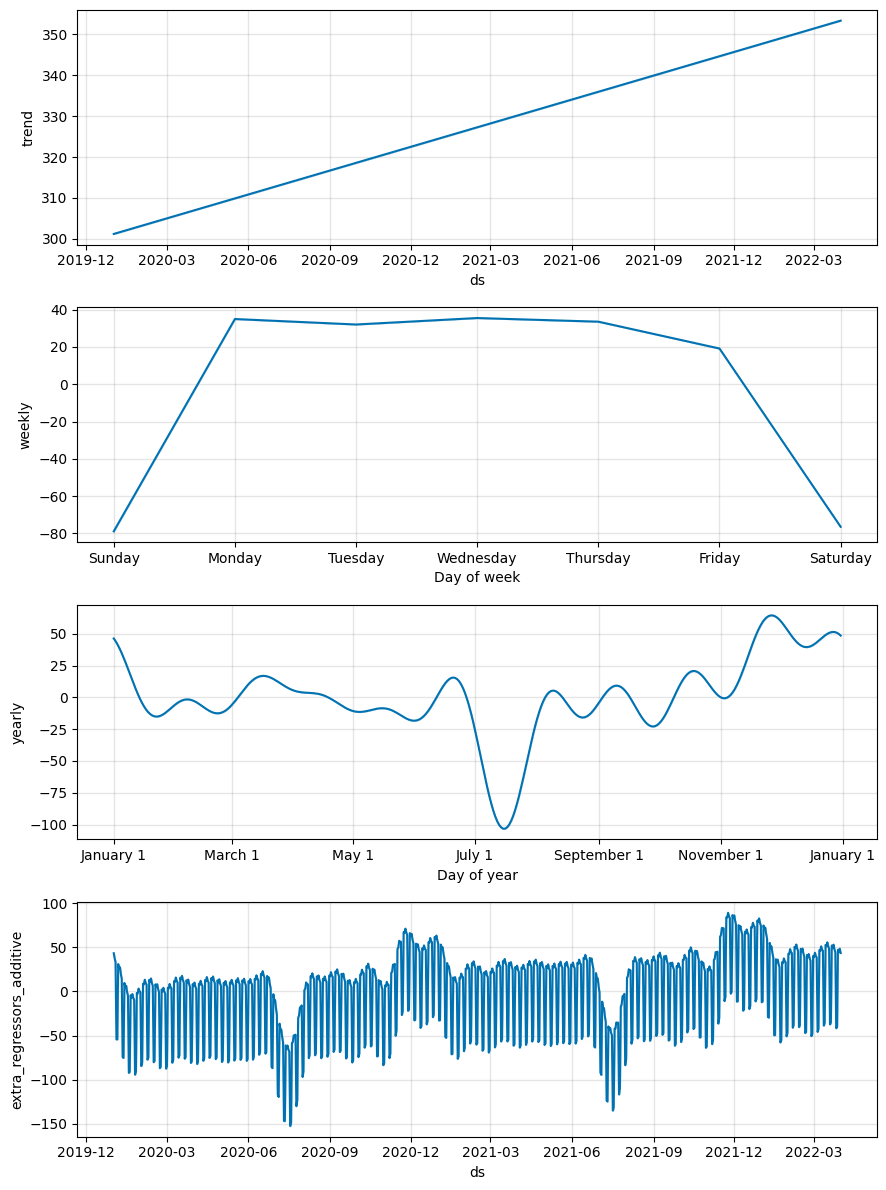

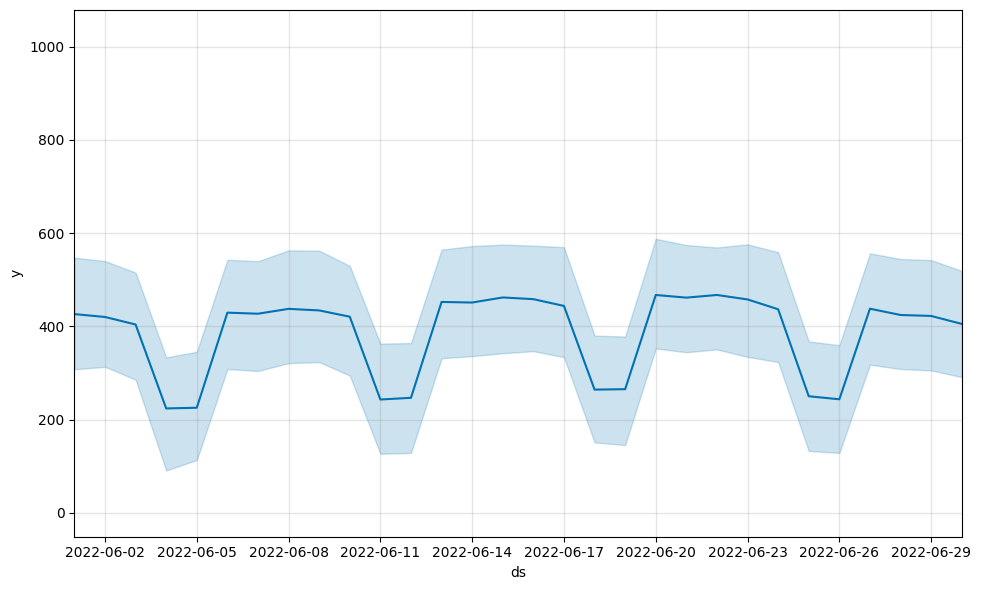

In [1927]:
draw_component_prog_June(cool_model, cool_df_train, cool_df_test, june_total_package_forecast)

Medelvärdet av fel för varje dag i testdatan: 49.013825695109176


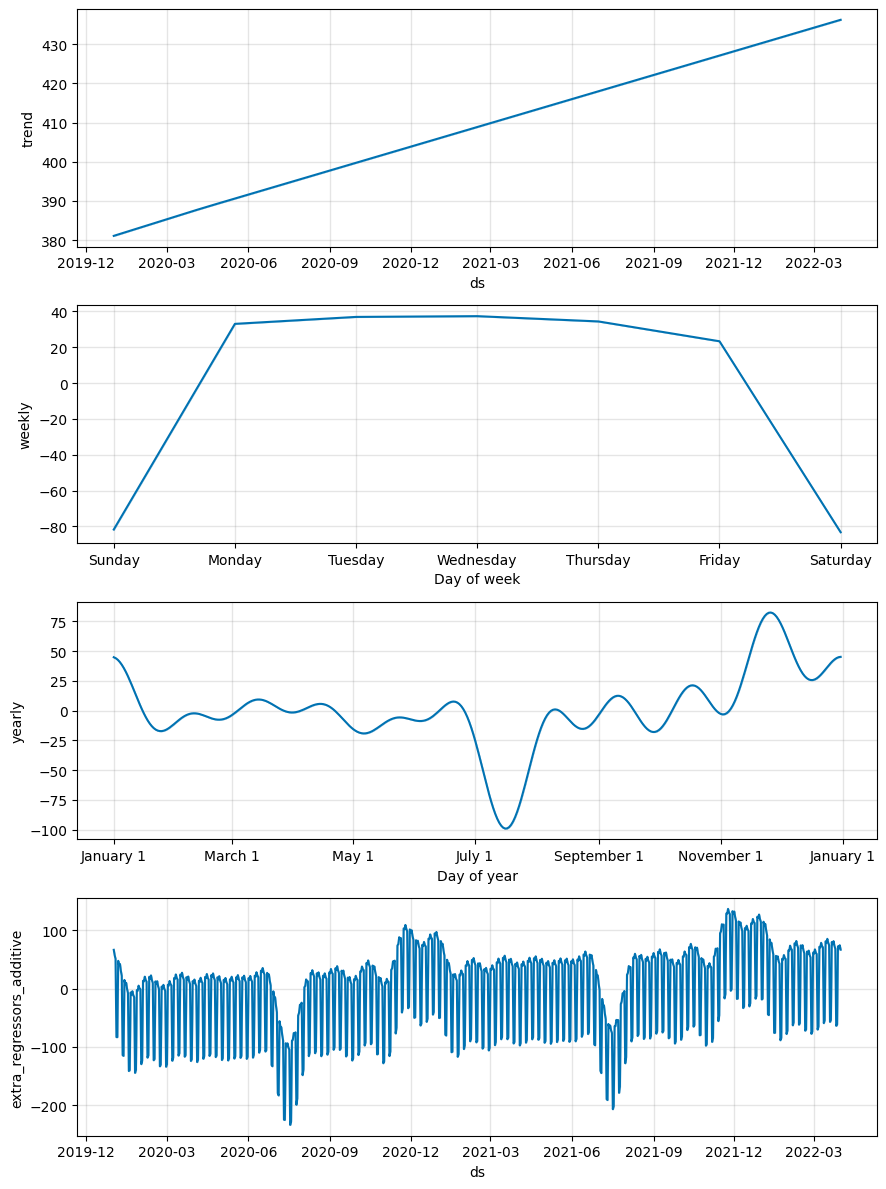

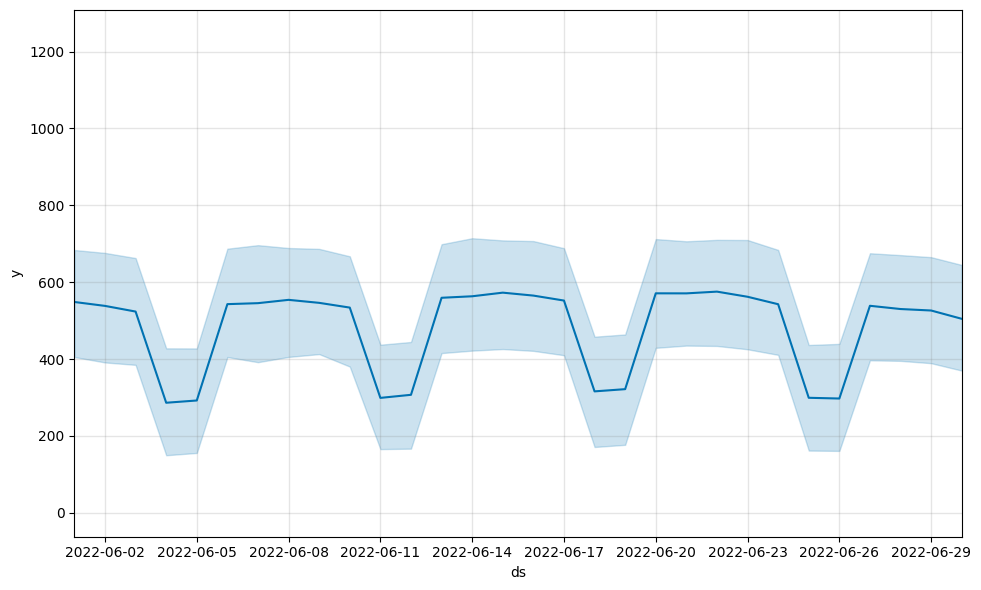

In [1928]:
draw_component_prog_June(fire_model, fire_df_train, fire_df_test, june_total_package_forecast)

Medelvärdet av fel för varje dag i testdatan: 114.31344492558169


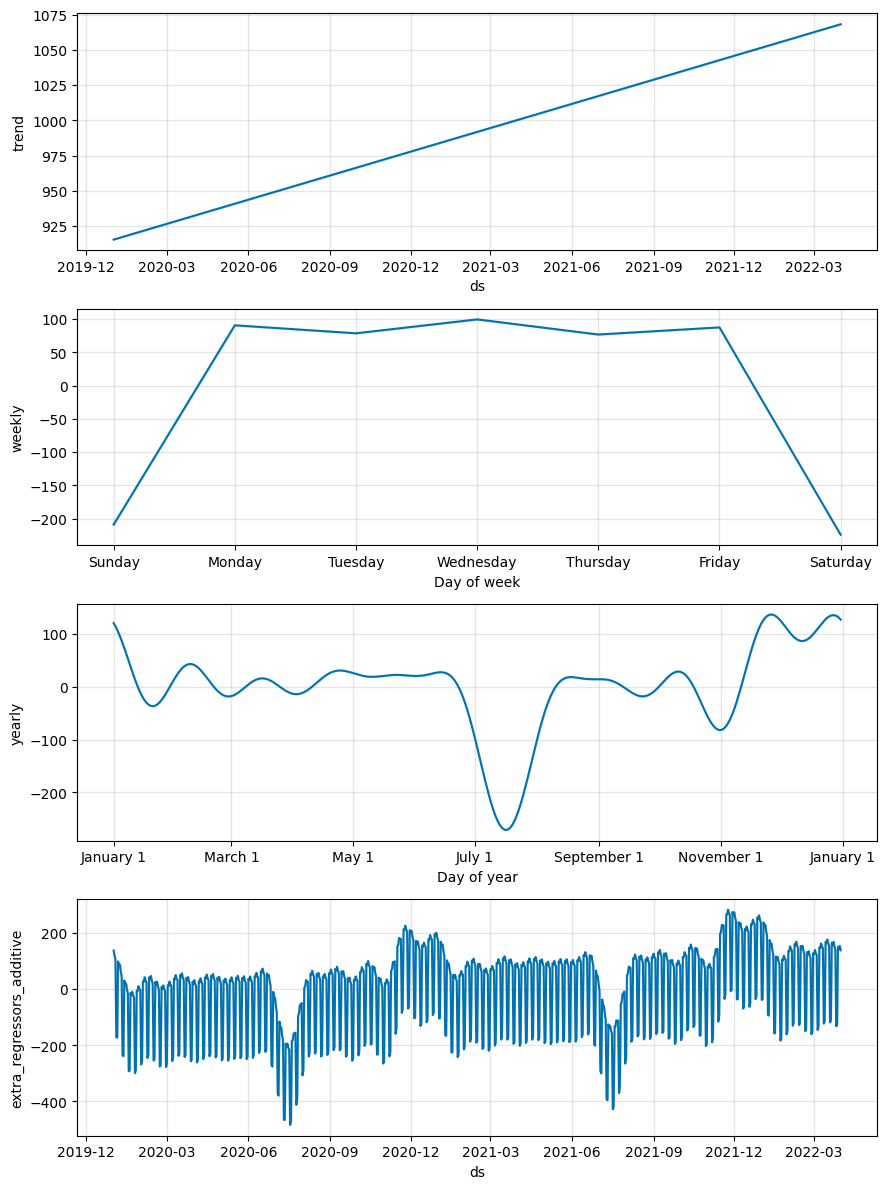

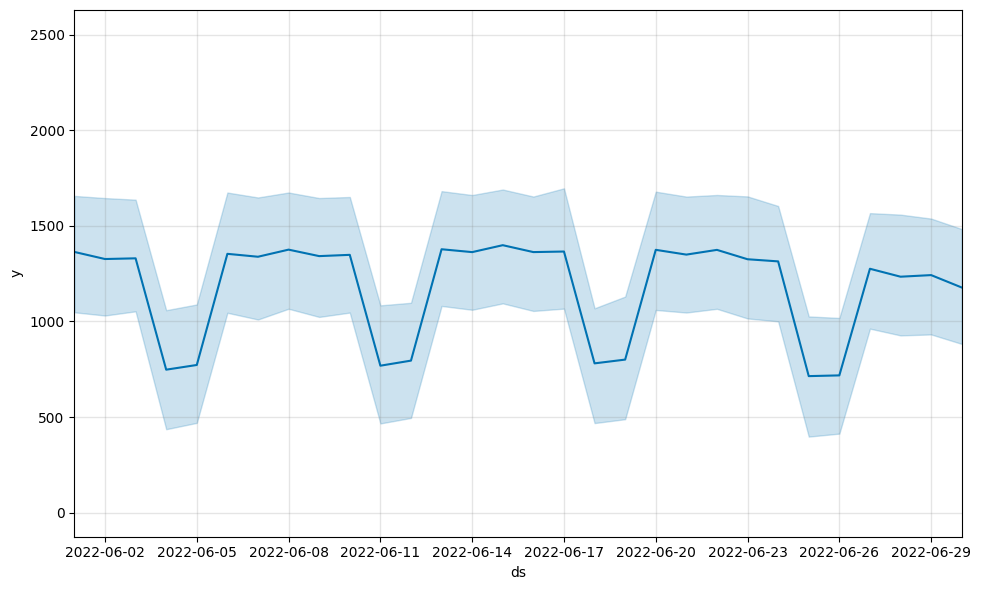

In [1929]:
draw_component_prog_June(normal_model, normal_df_train, normal_df_test, june_total_package_forecast)